In [27]:
import re

NUM = r'([0-9]+(?:\.[0-9]+)?(?:[eE][-+]?[0-9]+)?)'

def parse_file(filename):
    with open(filename, "r") as f:
        content = f.read()

    # Get blocks between Begin/End (robust to exact number of dashes)
    blocks = re.findall(r"-+Begin-+\s*(.*?)\s*-+End-+", content, flags=re.DOTALL)

    results = []
    for bi, block in enumerate(blocks, start=1):

        def grab(pattern, name, text=block, flags=re.DOTALL):
            m = re.search(pattern, text, flags=flags)
            if not m:
                raise ValueError(f"[Block {bi}] Could not find {name} with pattern:\n{pattern}\n--- Block ---\n{text}\n")
            return m.group(1)

        # ---- top-level fields ----
        real_sparsity = float(grab(rf"Real Sparsity matmul_m_mnc:{NUM}", "real_sparsity"))
        real_nnz = float(grab(rf"real_nnz:{NUM}", "real_nnz"))

        # ---- split out sections ----
        # MNC section is everything between "MNC:" and "Estimator:"
        mnc_section = grab(r"MNC:\s*(.*?)\s*Estimator:", "mnc_section")
        # Estimator section is everything after "Estimator:" (until end of block)
        est_section = grab(r"Estimator:\s*(.*)$", "estimator_section")

        # ---- parse MNC ----
        mnc_sparsity = float(grab(rf"Sparsity:{NUM}", "mnc_sparsity", text=mnc_section))
        mnc_nnz = float(grab(rf"mnc_nnz:{NUM}", "mnc_nnz", text=mnc_section))
        mnc_error = float(grab(rf"Relative error:{NUM}", "mnc_error", text=mnc_section))
        mnc_rep = grab(r"\b(Same|Diff)\s+Rep\b", "mnc_rep", text=mnc_section, flags=0)

        results.append({
            "real_sparsity": real_sparsity,
            "real_nnz": real_nnz,
            "mnc_sparsity": mnc_sparsity,
            "mnc_nnz": mnc_nnz,
            "mnc_error": mnc_error,
            "mnc_rep": mnc_rep,
        })

    return results


file = "../result/run_elementwise_mul.txt"
results = parse_file(file)

for i, r in enumerate(results, start=1):
    print(f"Block {i}: real_s={r['real_sparsity']}, real_nnz={r['real_nnz']}")
    print(f"  MNC      : s={r['mnc_sparsity']}, nnz={r['mnc_nnz']}, err={r['mnc_error']}, rep={r['mnc_rep']}")

Block 1: real_s=0.298898, real_nnz=1302.0
  MNC      : s=0.304178, nnz=1325.0, err=1.01767, rep=Same
Block 2: real_s=0.00207641, real_nnz=1403.0
  MNC      : s=0.00206901, nnz=1398.0, err=1.00358, rep=Same
Block 3: real_s=0.00213561, real_nnz=1443.0
  MNC      : s=0.00209121, nnz=1413.0, err=1.02123, rep=Same
Block 4: real_s=0.0302041, real_nnz=37.0
  MNC      : s=0.0228571, nnz=28.0, err=1.32143, rep=Same
Block 5: real_s=0.0181141, real_nnz=11593.0
  MNC      : s=0.0180391, nnz=11545.0, err=1.00416, rep=Same
Block 6: real_s=0.00156406, real_nnz=1001.0
  MNC      : s=0.00150156, nnz=961.0, err=1.04162, rep=Same
Block 7: real_s=0.00459531, real_nnz=2941.0
  MNC      : s=0.00438125, nnz=2804.0, err=1.04886, rep=Same
Block 8: real_s=0.0029815, real_nnz=11926.0
  MNC      : s=0.00299925, nnz=11997.0, err=1.00595, rep=Same
Block 9: real_s=0.0029815, real_nnz=11926.0
  MNC      : s=0.00299925, nnz=11997.0, err=1.00595, rep=Same
Block 10: real_s=0.00907372, real_nnz=120.0
  MNC      : s=0.009

In [28]:
import numpy as np

def ratio_err(a, b, eps=1.0):
    # eps=1 for NNZ works well (prevents div-by-zero explosions)
    a = max(float(a), eps)
    b = max(float(b), eps)
    return max(a, b) / min(a, b)

# --- choose how to read nnz from your dicts ---
def get_real_nnz(r):
    # preferred: already stored
    if "real_nnz" in r:
        return r["real_nnz"]
    # fallback: from density+sized block
    if "real_density" in r and "cells" in r:
        return r["real_density"] * r["cells"]
    raise KeyError("Need real_nnz or (real_density and cells)")

def get_mnc_nnz(r):
    if "mnc_nnz" in r:
        return r["mnc_nnz"]
    if "mnc_density" in r and "cells" in r:
        return r["mnc_density"] * r["cells"]
    raise KeyError("Need mnc_nnz or (mnc_density and cells)")


real_total = sum(get_real_nnz(r) for r in results)
mnc_total  = sum(get_mnc_nnz(r)  for r in results)

print("Paper-style FINAL ratio error (aggregated NNZ):")
print("  MNC:", ratio_err(mnc_total, real_total))

Paper-style FINAL ratio error (aggregated NNZ):
  MNC: 1.0000415472184137


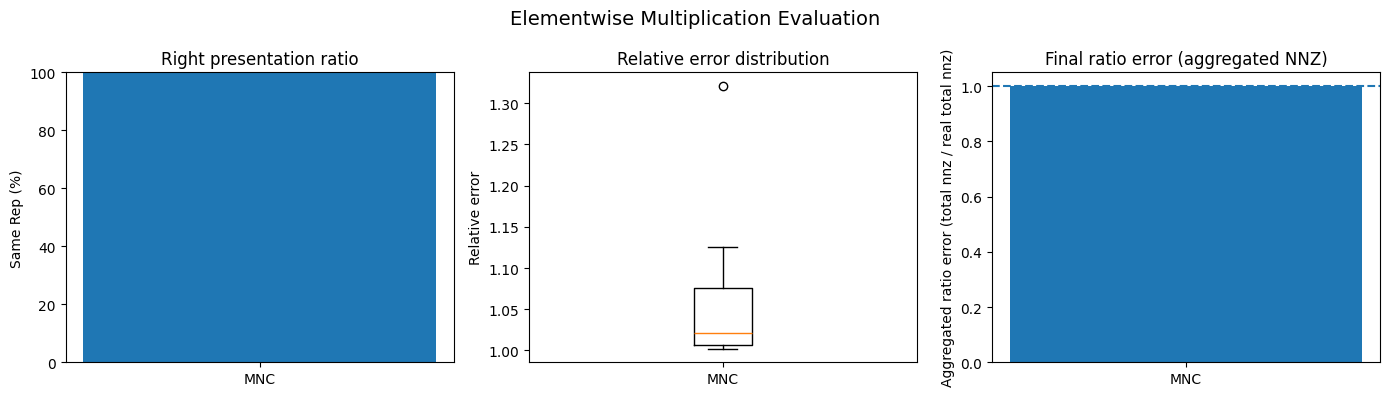

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- percentages (Same Rep) ---
results_len = len(results)
mnc_same_pct = 100 * sum(1 for r in results if r["mnc_rep"] == "Same") / results_len

# --- relative errors (per block) ---
mnc_err = np.array([r["mnc_error"] for r in results], dtype=float)

real_total = sum(float(r["real_nnz"]) for r in results)
mnc_total  = sum(float(r["mnc_nnz"]) for r in results)

mnc_final_ratio = ratio_err(mnc_total, real_total)

# ---- plotting (3 panels) ----
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# --- Global title ---
fig.suptitle("Elementwise Multiplication Evaluation", fontsize=14)
# Plot 1: Same Rep %
ax1.bar(["MNC"], [mnc_same_pct])
ax1.set_ylim(0, 100)
ax1.set_ylabel("Same Rep (%)")
ax1.set_title("Right presentation ratio")

# Plot 2: Relative error distribution
ax2.boxplot([mnc_err], tick_labels=["MNC"], showfliers=True)
ax2.set_ylabel("Relative error")
ax2.set_title("Relative error distribution")

# Plot 3: Aggregated NNZ ratio error (paper-style final)
ax3.bar(["MNC"], [mnc_final_ratio])
ax3.axhline(1.0, linestyle="--")  # perfect ratio line
ax3.set_ylabel("Aggregated ratio error (total nnz / real total nnz)")
ax3.set_title("Final ratio error (aggregated NNZ)")

plt.tight_layout()
plt.show()

In [30]:
print("From Paper: B2.5: 1.0")
print("Mnc final ratio error:", mnc_final_ratio)

From Paper: B2.5: 1.0
Mnc final ratio error: 1.0000415472184137
